# 因子分析

快速提示：

1. 因子分析的主要目标是降维：把大量的变量缩减为较少的因子。
2. 主要过程包括：
   - 选择因子数量
   - 计算成分矩阵，对因子进行解释和有意义的命名
   - 计算因子得分
3. 还有另一种常见的降维方法“主成分分析PCA”，不是本节内容。但是学会本节之后，看PCA的教程也会很容易上手。
4. 本节忽略数学过程，主要解释原理和实践。


## 介绍因子分析

因子分析是一种常用的多变量统计方法，旨在识别数据中潜在的、不可观测的因子结构。这些潜在因子可以解释观察到的变量之间的相关性，帮助我们理解数据背后的内在结构和规律。因子分析通常用于数据降维、变量相关性分析和潜在因子的发现。

在本节中，我们将介绍因子分析的基本概念和应用，以及在Python中如何进行因子分析的实践操作。首先，我们将学习如何准备数据并选择合适的变量进行因子分析。然后，我们将详细介绍主成分分析（PCA）和因子分析（Factor Analysis）这两种常用的因子分析方法，并演示如何使用Python库来实现这些方法。通过本节的学习，你将能够掌握因子分析的基本原理，并具备运用Python进行因子分析的实际能力。


### 安装需要用到的包

这里要用到 `factor_analyzer`，可以从清华大学的pip镜像安装。首次执行之前，在任何一个python的单元格中执行下面代码，注意前面有个感叹号：

```
!pip install -i https://pypi.tuna.tsinghua.edu.cn/simple factor_analyzer
```

当然，安装完毕之后，以后使用就不用再安装了。

### 数据准备

BFI数据集（Big Five Inventory）是一个常用的心理学研究工具，用于评估个体的五个主要人格特质：外向性、宜人性、尽责性、神经质和开放性。这个数据集通常包含一系列关于被调查者的问题，用于量化这些人格特质。

BFI数据集包括以下几类问题：


1. **宜人性（Agreeableness）**: 衡量个体的善良、合作和信任程度。
2. **尽责性（Conscientiousness）**: 衡量个体的目标导向、自律和责任心。
3. **外向性（Extraversion）**: 衡量个体的社交性、外向性和活跃性。
4. **神经质（Neuroticism）**: 衡量个体的情绪稳定性和神经质程度。
5. **开放性（Openness）**: 衡量个体的对新事物的接受程度、创造力和想象力。

每个人格特质通常由多个问题组成，被调查者根据自己的感受选择相应的答案，通常是在一个有限的范围内（例如1到5或1到7）。



数据下载： [bfi.csv](data/bfi.csv)。右键另存为即可，记得放在“合理的位置”。

In [191]:
import pandas as pd
import numpy as np

# 读取和简单查看数据
df_full = pd.read_csv("data/bfi.csv")
df_full.head()

,rownames,A1,A2,A3,A4,A5,C1,C2,C3,C4,...,N4,N5,O1,O2,O3,O4,O5,gender,education,age
0,61617,2.0,4.0,3.0,4.0,4.0,2.0,3.0,3.0,4.0,...,2.0,3.0,3.0,6,3.0,4.0,3.0,1,NaN,16
1,61618,2.0,4.0,5.0,2.0,5.0,5.0,4.0,4.0,3.0,...,5.0,5.0,4.0,2,4.0,3.0,3.0,2,NaN,18
2,61620,5.0,4.0,5.0,4.0,4.0,4.0,5.0,4.0,2.0,...,2.0,3.0,4.0,2,5.0,5.0,2.0,2,NaN,17
3,61621,4.0,4.0,6.0,5.0,5.0,4.0,4.0,3.0,5.0,...,4.0,1.0,3.0,3,4.0,3.0,5.0,2,NaN,17
4,61622,2.0,3.0,3.0,4.0,5.0,4.0,4.0,5.0,3.0,...,4.0,3.0,3.0,3,4.0,3.0,3.0,1,NaN,17


In [192]:
# 查看列名
df_full.columns

Index(['rownames', 'A1', 'A2', 'A3', 'A4', 'A5', 'C1', 'C2', 'C3', 'C4', 'C5',
       'E1', 'E2', 'E3', 'E4', 'E5', 'N1', 'N2', 'N3', 'N4', 'N5', 'O1', 'O2',
       'O3', 'O4', 'O5', 'gender', 'education', 'age'],
      dtype='object')

In [193]:
# 数据清洗
# 我们的目标是对BFI信息进行因子分析，因此先去掉用不到的信息
df = df_full.drop(["rownames", "gender", "education", "age"], axis=1)

# 查看列标题，和列数，和行数
(df.columns, len(df.columns), len(df))

(Index(['A1', 'A2', 'A3', 'A4', 'A5', 'C1', 'C2', 'C3', 'C4', 'C5', 'E1', 'E2',
        'E3', 'E4', 'E5', 'N1', 'N2', 'N3', 'N4', 'N5', 'O1', 'O2', 'O3', 'O4',
        'O5'],
       dtype='object'),
 25,
 2800)

可见这份问卷有25个问题。

In [194]:
# 去除缺缺失值的样本
df.dropna(inplace=True)

## 适用性检验

1. Bartlett's Test(巴特利特球形度检验):
   巴特利特检验用于检验变量之间是否存在显著的相关性。它的**原假设是假设变量之间没有显著的相关性,即相关矩阵是一个单位矩阵**。如果检验的p值小于显著性水平(通常取0.05),则拒绝原假设,认为变量之间存在显著相关性,数据适合进行因子分析。
   
   简单来说,巴特利特检验就是判断变量之间的相关性是否显著。如果变量间的相关性越显著,则越适合进行因子分析,因为因子分析的目的就是根据变量间的相关性提取共同因子。

2. Kaiser-Meyer-Olkin(KMO)测度:
   KMO测度用于衡量变量间相关性的强度,以判断是否适合进行因子分析。KMO值的取值范围在0到1之间。通常认为,KMO值大于0.6时,数据适合进行因子分析;KMO值在0.8以上时,数据非常适合进行因子分析。
   
   KMO测度的计算原理是比较变量间的简单相关系数和偏相关系数。如果变量间的偏相关系数较小,说明变量间的相关性主要来自它们共同的因子,此时KMO值较大,数据适合因子分析。反之,如果变量间的偏相关系数较大,则KMO值较小,数据不太适合因子分析。

综上,巴特利特检验和KMO测度都是用来判断数据是否适合进行因子分析的。巴特利特检验侧重于检验变量间相关性的显著性,而KMO测度侧重于衡量变量间相关性的强度。在实际应用中,我们通常结合这两个指标来综合评判数据是否适合因子分析。如果巴特利特检验的p值显著且KMO值较大,我们就可以比较放心地进行因子分析了。



In [195]:
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity, calculate_kmo
import pandas as pd

# 假设df是你的数据框
# 首先，计算Bartlett’s Test
bartlett_test_statistic, bartlett_p_value = calculate_bartlett_sphericity(df)
print("Bartlett's Test Statistic:", bartlett_test_statistic.round(2))
print("Bartlett's p-value:", bartlett_p_value)

Bartlett's Test Statistic: 18146.07
Bartlett's p-value: 0.0


解读 Bartlett's Test（巴特利特检验）：
   - Bartlett's Test Statistic（巴特利特检验统计量）为18146.07，这个值很大，表明数据之间存在显著的相关性。
   - Bartlett's p-value（巴特利特检验的p值）为0.0，小于显著性水平（通常取0.05），因此拒绝了球形检验的原假设，即数据之间存在显著的相关性，适合进行因子分析。

快速提示：特别大的统计量，约等于0的p值：拒变量“全部变量不相关”的原假设。既然最少部分变量之间是相关的，那么就有“合并同类项”的潜力。

In [196]:
# 接下来，计算Kaiser-Meyer-Olkin (KMO) Test
kmo_per_variable, kmo_total = calculate_kmo(df)
print("KMO per variable:", kmo_per_variable.round(2))
print("KMO Total:", kmo_total.round(2))

KMO per variable: [0.75 0.84 0.87 0.88 0.9  0.84 0.8  0.85 0.83 0.86 0.84 0.88 0.9  0.88
 0.89 0.78 0.78 0.86 0.89 0.86 0.86 0.78 0.84 0.77 0.76]
KMO Total: 0.85


解读 Kaiser-Meyer-Olkin（KMO）测度：
   - KMO per variable（每个变量的KMO值）给出了每个变量的KMO测度值，范围在0.75到0.90之间。通常，KMO值大于0.6被认为是适合进行因子分析的。在你的结果中，所有变量的KMO值都大于0.6，表明每个变量都适合进行因子分析。
   - KMO Total（总体KMO值）为0.85，这个值大于0.8，表明数据整体上非常适合进行因子分析。

快速提示：总体KMO > 0.8 适合因子分析。

综上所述，根据Bartlett's Test的结果，数据之间存在显著的相关性，拒绝了球形检验的原假设；同时，KMO测度的结果表明，每个变量以及整体数据都适合进行因子分析。这意味着你的数据满足了进行因子分析的基本假设，可以继续进行因子分析的后续步骤。



## 提取几个变量？

在进行因子分析时,确定提取因子的数量是一个重要的问题。以下是几种常用的确定提取因子数量的方法:

1. 特征值大于1原则(Kaiser准则):
   该方法保留特征值大于1的因子。特征值代表了每个因子可以解释的变量方差量。当一个因子的特征值小于1时,意味着该因子解释的方差量还不如一个单个变量。因此,通常认为特征值大于1的因子是应该保留的。

2. 碎石图(Scree Plot):
   碎石图是一个特征值与因子数量的折线图。通过观察折线图的形状,可以确定应该保留的因子数量。通常,我们寻找折线图中的"拐点",即折线开始变得平缓的地方。拐点之前的因子被认为是应该保留的。

3. 方差解释率:
   该方法根据因子解释总方差的比例来决定保留的因子数量。通常,我们希望保留的因子能够解释足够多的总方差,比如60%或70%。可以逐步增加因子数量,直到累积方差解释率达到满意的水平。

4. 平行分析(Parallel Analysis):
   平行分析通过随机数据模拟来确定应该保留的因子数量。它生成与实际数据相同样本量和变量数的随机数据集,并计算其特征值。然后,将实际数据的特征值与随机数据的特征值进行比较。只保留那些实际数据特征值大于随机数据特征值的因子。

5. 理论或先验知识:
   在某些情况下,研究者可能根据理论或先验知识已经知道应该提取的因子数量。这种情况下,可以直接指定提取的因子数量。

在实践中,通常综合考虑多种方法的结果,并结合研究问题的背景知识来决定提取的因子数量。此外,还需要考虑因子的可解释性和稳定性。提取的因子应该有明确的解释,并且在不同的样本中具有一致性。


### 特征值

In [197]:
from factor_analyzer import FactorAnalyzer

# 创建 FactorAnalyzer 对象
fa = FactorAnalyzer()

# 拟合因子分析模型
fa.fit(df)

# 获取特征值
eigenvalues, _ = fa.get_eigenvalues()

print(eigenvalues.round(2))

[5.13 2.75 2.14 1.85 1.55 1.07 0.84 0.8  0.72 0.69 0.68 0.65 0.62 0.6
 0.56 0.54 0.51 0.49 0.48 0.45 0.42 0.4  0.39 0.38 0.26]


快速提示：

1. 如果保留1个解释力最强的因子（25个变量缩到1个），可以解释 5.13 / 25 = 20.54%的方差。
2. 如果保留2个因子（25个变量缩减成2个），可以解释 (5.13 + 2.75) / 25 = 31.54%的方差。
3. 如此类推


计算累计方差解释率

In [198]:
pd.DataFrame(
    {
        "因子数": np.arange(1, len(eigenvalues) + 1),
        "累计方差解释率%": np.cumsum(eigenvalues / len(eigenvalues)).round(4) * 100,
    }
).head(10)

,因子数,累计方差解释率%
0,1,20.54
1,2,31.54
2,3,40.12
3,4,47.52
4,5,53.72
5,6,58.01
6,7,61.37
7,8,64.57
8,9,67.44
9,10,70.20


In [199]:
# 根据特征值大于1的原则确定要提取的因子数量
num_factors = sum(eigenvalues > 1)
print(f"根据特征值大于1的原则,应提取 {num_factors} 个因子。")

根据特征值大于1的原则,应提取 6 个因子。


### 碎石图

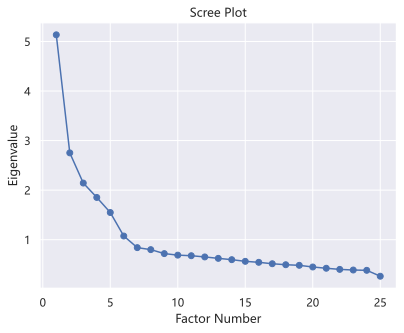

In [200]:
import matplotlib.pyplot as plt


# 绘制碎石图
plt.plot(range(1, len(eigenvalues) + 1), eigenvalues, "bo-")
plt.xlabel("Factor Number")
plt.ylabel("Eigenvalue")
plt.title("Scree Plot")
plt.grid(True)
plt.show()

解释:

- 碎石图将特征值按照从大到小的顺序绘制在坐标轴上,横轴表示因子的编号,纵轴表示对应的特征值。
- 我们通常 **寻找碎石图中的"拐点"** ,即图形开始变得平缓的地方。拐点之前的因子被认为是应该保留的,因为它们对应着较大的特征值,解释了较多的方差。
- 在你的碎石图中,我们可以观察到前6到7个因子对应的特征值下降较快,之后的特征值下降变缓。因此,可以考虑将拐点定在第6或者第7个因子。

两种方法结合看，可以取6个因子。即我们会把**25个变量，缩减成6个因子**。

## 计算（旋转）成分矩阵

已经确定提取6个因子,那么我们可以计算成分矩阵(Component Matrix)或因子负荷矩阵(Factor Loading Matrix)。成分矩阵表示每个原始变量与提取的因子之间的相关性或负荷。

- 成分矩阵中的每个元素表示原始变量与因子之间的相关性,即该变量在因子上的负荷。
- 负荷的取值范围通常在-1到1之间,绝对值越大表示变量与因子的关联越强。
- 每个变量在不同因子上的负荷可以帮助我们理解变量与因子之间的关系,并解释因子的含义。
- 通常,我们会对成分矩阵进行旋转(如varimax旋转),以获得更清晰和可解释的因子结构。

In [201]:
# 创建 FactorAnalyzer 对象,指定要提取的因子数量
fa = FactorAnalyzer(n_factors=6, rotation="varimax")

# 拟合因子分析模型
fa.fit(df)

# 获取成分矩阵(因子负荷矩阵)
component_matrix = fa.loadings_


component_df = pd.DataFrame(component_matrix.round(4))
component_df.index = df.columns
component_df.columns = [
    "Factor " + str(i + 1) for i in range(len(component_df.columns))
]

# 打印成分矩阵
print("成分矩阵:")
component_df

成分矩阵:


,Factor 1,Factor 2,Factor 3,Factor 4,Factor 5,Factor 6
A1,0.0952,0.0408,0.0487,-0.5310,-0.1131,0.1612
A2,0.0331,0.2355,0.1337,0.6611,0.0637,-0.0062
A3,-0.0096,0.3430,0.1214,0.6059,0.0340,0.1601
A4,-0.0815,0.2197,0.2351,0.4046,-0.1253,0.0864
A5,-0.1496,0.4145,0.1064,0.4697,0.0310,0.2365
C1,-0.0044,0.0772,0.5546,0.0075,0.1901,0.0950
C2,0.0683,0.0384,0.6745,0.0571,0.0876,0.1528
C3,-0.0400,0.0319,0.5512,0.1013,-0.0113,0.0090
C4,0.2163,-0.0662,-0.6385,-0.1026,-0.1438,0.3184
C5,0.2842,-0.1808,-0.5448,-0.0600,0.0258,0.1324


成分矩阵的行和列分别代表原始变量和提取的因子,它们的交叉处表示变量与因子之间的关系强度。

行(Rows):

- 每一行对应一个原始变量,比如第一行可能对应变量"A1",第二行对应"A2",以此类推。
- 每一行都有6个数值(因为我们提取了6个因子),表示该变量在每个因子上的负荷(Loading)。

列(Columns):

- 每一列对应一个提取的因子,比如第一列对应第一个因子,第二列对应第二个因子,以此类推。
- 每一列都有25个数值(因为有25个原始变量),表示每个变量在该因子上的负荷。


### 成分矩阵的解释

成分矩阵，反映了“变量受到因子的影响程度”。

让我们关注在因子1上负荷绝对值较大的变量(如大于0.4):

- 变量"N1"(第16行)在因子1上的负荷为0.7914
- 变量"N2"(第17行)在因子1上的负荷为0.7874
- 变量"N3"(第18行)在因子1上的负荷为0.7235
- 变量"N4"(第19行)在因子1上的负荷为0.5670
- 变量"N5"(第20行)在因子1上的负荷为0.5188

这些变量在因子1上有较高的正向负荷,表明它们与因子1有很强的正向关系。当因子1的得分增加时,这些变量的值也倾向于增加。
其他变量在因子1上的负荷相对较小,表明它们与因子1的关系较弱。


## 因子的解释和命名

在获得旋转成分矩阵后,下一步是解释和命名因子,以理解它们的实际含义。这是因子分析中非常重要的一步,因为它将统计结果与实际问题联系起来。以下是一些详细的步骤:

1. 检查每个因子的高载荷变量:

   - 对于每个因子,找出载荷绝对值较大的变量(例如,大于0.4或0.5)。
   - 这些变量在定义和解释因子方面起着重要作用。

2. 根据高载荷变量的共同特征命名因子:

   - 检查在每个因子上载荷较高的变量,看它们是否有一些共同的主题或概念。
   - 根据这些共同特征,给每个因子起一个描述性的名称,以反映其潜在的含义。
   - 例如,如果在一个因子上载荷较高的变量都与创造力相关,你可能会将该因子命名为"创造力因子"。

以因子1为例

In [202]:
factor = component_df["Factor 1"]
factor[np.abs(factor) > 0.4]

N1    0.8058
N2    0.7898
N3    0.7251
N4    0.5783
N5    0.5231
Name: Factor 1, dtype: float64

因子1和N类问题高度相关，N表示"神经质"(Neuroticism)，既然如此，我们可以把因子1称之为“神经质因子”



In [203]:
component_df.rename({"Factor 1": "神经质因子"}, inplace=True, axis=1)
component_df.head()

,神经质因子,Factor 2,Factor 3,Factor 4,Factor 5,Factor 6
A1,0.0952,0.0408,0.0487,-0.5310,-0.1131,0.1612
A2,0.0331,0.2355,0.1337,0.6611,0.0637,-0.0062
A3,-0.0096,0.3430,0.1214,0.6059,0.0340,0.1601
A4,-0.0815,0.2197,0.2351,0.4046,-0.1253,0.0864
A5,-0.1496,0.4145,0.1064,0.4697,0.0310,0.2365


注意：模型选出的多个变量，合并起来能表示什么含义，这可能需要你进行深入思考。例如，因子1和'语文成绩'和'政治成绩'高度相关，那么因子1可能可以被命名为"文科成绩"。但是原始数据中，不见得有一道题会明确提出"文科成绩"这几个字。

## 计算因子得分

成分矩阵表示“变量和因子”之间的关系，有了这个关系，我们可以对原始数据中的每一个样本，计算出6个因子得分。

In [204]:
# 计算因子得分
factor_scores = np.dot(df, component_matrix)

In [205]:
# 把上述因子得分，转为df
import pandas as pd

factor_scores_df = pd.DataFrame(factor_scores, columns=component_df.columns)
factor_scores_df.round(3)

,神经质因子,Factor 2,Factor 3,Factor 4,Factor 5,Factor 6
0,13.488,6.353,3.495,7.828,-0.120,9.982
1,14.608,10.385,6.990,10.014,4.307,11.343
2,16.508,9.028,8.396,7.914,5.369,11.054
3,13.579,7.489,5.114,8.835,1.195,12.394
4,12.624,9.710,8.637,8.908,3.064,10.559
...,...,...,...,...,...,...
2431,22.223,0.926,5.536,4.753,5.013,10.317
2432,17.312,9.043,7.039,8.600,7.333,12.737
2433,11.410,12.545,12.564,9.389,8.109,10.384
2434,18.355,8.785,8.044,4.889,6.536,10.908


对于2800个个案，我们把每个人的25个问题压缩成了6个因子，并且给每个因子都进行了解释和命名（后面几个这里省略）。我们可以把个人信息也添加进去。

In [206]:
# 把原始数据 df_full中的个人特征添加到因子得分矩阵
factor_scores_df = pd.concat(
    [factor_scores_df, df_full[["gender", "education", "age"]]], axis=1
)
factor_scores_df.head()

,神经质因子,Factor 2,Factor 3,Factor 4,Factor 5,Factor 6,gender,education,age
0,13.488157,6.353063,3.495437,7.827643,-0.119923,9.982443,1,NaN,16
1,14.608377,10.384923,6.989947,10.013639,4.306944,11.342509,2,NaN,18
2,16.507707,9.027630,8.396385,7.913944,5.368839,11.053655,2,NaN,17
3,13.579167,7.488870,5.113725,8.835127,1.194828,12.394103,2,NaN,17
4,12.624217,9.709716,8.637475,8.907972,3.064179,10.559332,1,NaN,17


这样，我们就把原始数据，从原来的25个问题+个人信息，降维成了6个因子+个人信息。



### 因子得分 vs 原始数据

在许多情况下,我们可以使用因子得分来代替原始数据进行后续分析。这有几个主要的优点:

1. 数据简化:原始数据通常包含大量变量,可能存在多重共线性问题。使用因子得分可以将这些变量归结为几个关键的潜在构念,从而简化数据结构。

2. 降维:因子分析是一种降维技术。通过将原始变量转化为少数几个因子,我们可以在保留大部分信息的同时,大大减少数据的维度。这可以使后续分析更加简单和高效。

3. 去除噪音:原始变量可能包含一些测量误差或不相关的噪音。因子分析通过提取共同的潜在因子,可以在一定程度上去除这些噪音,使得后续分析更加稳健。

4. 有意义的解释:因子往往代表了一些有意义的潜在构念。使用因子得分进行分析,可以直接研究这些构念,而不是个别的观测变量。这可以使结果更具理论意义和解释价值。

然而,在某些情况下,你可能仍然需要使用原始数据:

1. 当你对特定变量感兴趣时:如果你的研究问题涉及某个特定的变量,而不是整体的潜在构念,那么你可能需要直接使用这个变量,而不是因子得分。

2. 当因子的解释不清晰时:如果提取的因子难以解释,或者不能很好地代表原始变量,那么使用因子得分可能会导致信息损失或误导性结果。

3. 当你需要与其他研究进行比较时:如果你的研究需要与使用原始变量的其他研究进行比较,那么你可能需要报告原始变量的结果。

因此,是否使用因子得分取决于你的具体研究问题和目的。在许多情况下,因子得分可以提供一种简化、稳健和有意义的方式来分析数据。但在某些情况下,直接使用原始变量可能更合适。



## 综合作业

如果我们尝试解释5号和6号因子


In [207]:
factor = component_df["Factor 5"]
factor[np.abs(factor) > 0.4]

O1    0.4795
O2   -0.4966
O3    0.5661
O5   -0.5767
Name: Factor 5, dtype: float64

In [208]:
factor = component_df["Factor 6"]
factor[np.abs(factor) > 0.4]

Series([], Name: Factor 6, dtype: float64)

我们会发现，5号因子和"O"类型变量高度相关，但6号因子和任何一个变量都没有显著相关，这意味着我们在计算因子数量的时候可能多算了1个：可能5个就够了。

要求：

1. 按5个因子来完成因子分析的过程，并给每一个因子选择合适的命名。
2. 选择合适的方法，回答：
   1. 3号因子（用你取的名称），在男性和女性之间有没有显著差异？
   2. 1号因子（用你取的名称），会因为教育程度的不同而不同吗？
   3. 5号因子（用你取的名称），如何随着年龄而改变？
   
注意：

1. 处理之前记得剔除缺失值，如果你的数据名为`df`，则用`df.dropna(inplace = True)`即可剔除`df`中的缺失值。
2. 方法都在前面的章节，可以看每章开头的快速提示。
3. 这是开放式问题，原则上没有标准答案，但肯定有合理的答案。
